This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter

In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as precond_lib 

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib

from bnpgmm_runjingdev import hessian_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

import scipy as osp

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

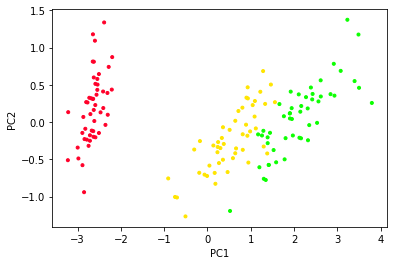

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.0])
print(prior_params_dict)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 30

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1731.7713604176683

# Optimize the KL objective

### Initialize with k-means

In [9]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 3445)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
6580.095037059639


In [10]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

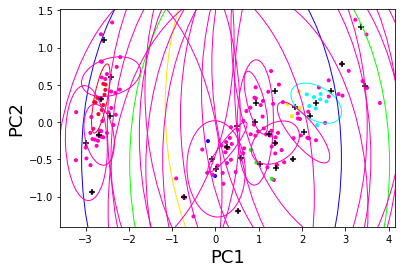

In [11]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [12]:
vb_params_dict = deepcopy(init_vb_params_dict)

## Run CAVI

In [13]:
x_tol = 1e-3

In [14]:
vb_cavi_dict, e_z_cavi = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False, 
                                            x_tol = x_tol)

done. num iterations = 100
stick_time: 0.558sec
cluster_time: 0.052sec
e_z_time: 0.141sec
**TOTAL time: 1.673sec**


In [15]:
vb_cavi_free = vb_params_paragami.flatten(vb_cavi_dict, free = True)

### Run newton; we will compare LR results later

In [16]:
continue_with_newton = True

In [17]:
if continue_with_newton: 
    
    get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

    get_loss_objective = \
        paragami.OptimizationObjective(lambda x : \
                                       get_vb_params_loss(features, x, prior_params_dict, gh_loc, gh_weights))
    
    res = osp.optimize.minimize(
                fun=get_loss_objective.f,
                jac=get_loss_objective.grad,
                hessp=get_loss_objective.hessian_vector_product,
                x0=deepcopy(vb_cavi_free), 
                method='trust-ncg', options={'disp':True})
    
    
    print('\nlinf diff in vb_params: ', np.abs(res.x - vb_cavi_free).max())
    
    vb_newton_free = deepcopy(res.x)
    vb_newton_dict = vb_params_paragami.fold(vb_newton_free, free = True)
    ez_newton = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_newton_dict,
                                                        gh_loc, gh_weights)


Iter 0: f = -388.28035483
Iter 1: f = -388.28046492
Iter 2: f = -388.28046506
Iter 3: f = -388.28046507
Optimization terminated successfully.
         Current function value: -388.280465
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 72

linf diff in vb_params:  0.00933050693387133


Text(0.5, 0, 'diff in vb free params')

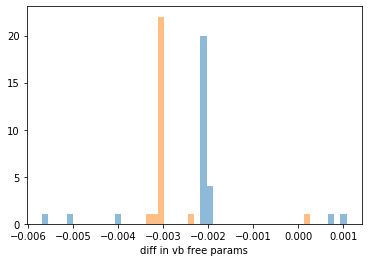

In [18]:
if continue_with_newton: 
    bins = plt.hist((vb_newton_free - vb_cavi_free)[utils_lib.get_param_indices('stick_propn_mean', 
                                                               vb_params_dict, vb_params_paragami)],
             alpha = 0.5, bins = 50)
    plt.hist((vb_newton_free - vb_cavi_free)[utils_lib.get_param_indices('stick_propn_info', 
                                                                         vb_params_dict, vb_params_paragami)],
             alpha = 0.5, bins=bins[1]);
    

plt.xlabel('diff in vb free params')

Text(0.5, 0, 'diff in vb free params')

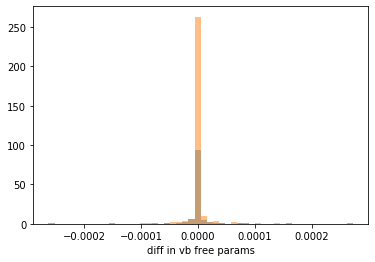

In [19]:
if continue_with_newton: 
    bins = plt.hist((vb_newton_free - vb_cavi_free)[utils_lib.get_param_indices('centroids', 
                                                               vb_params_dict, vb_params_paragami)],
             alpha = 0.5, bins = 50)
    plt.hist((vb_newton_free - vb_cavi_free)[utils_lib.get_param_indices('cluster_info', 
                                                                         vb_params_dict, vb_params_paragami)],
             alpha = 0.5, bins=bins[1]);
    
plt.xlabel('diff in vb free params')

# Check CAVI results

Text(0, 0.5, 'PC2')

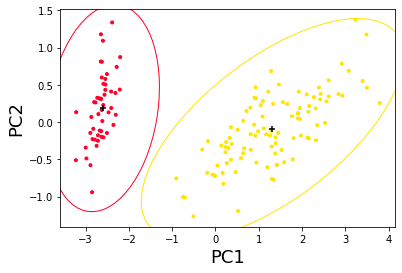

In [20]:
# optimization results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_cavi_dict, e_z_cavi, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Parametric sensitivity

### Get the hyper parameter sensitivity object

In [21]:
use_free_alpha = True
prior_alpha = prior_params_paragami['alpha'].flatten(prior_params_dict['alpha'], free = use_free_alpha)

In [22]:
def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['alpha'] = alpha
    
    return gmm_lib.get_kl(features, vb_params_dict, _prior_params_dict,
                    gh_loc, gh_weights)

In [23]:
objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

# solve the linear system

In [24]:
def get_nystrom_preconditioner(vb_opt, e_z_opt): 
    k_large = 5
    which_k = np.argsort(-e_z_opt.mean(0))[0:k_large]

    sub_block_hess, indx = hessian_lib.get_large_clusters_hessian(features, which_k, vb_opt, vb_params_paragami, 
                                                                      prior_params_dict, gh_loc, gh_weights)

    est_lambda_max = np.abs(sub_block_hess).sum(1).max()
    nystrom_precond = preconditioner_lib.get_nystrom_woodbury_precon(sub_block_hess, indx, est_lambda_max)
    
    return nystrom_precond

In [25]:
get_full_hessian = False 

if get_full_hessian:
    hess_solver = None
else: 
    # get cg solver 
    # preconditioner = precond_lib.get_gmm_preconditioner(vb_cavi_free, vb_params_paragami)
    preconditioner = get_nystrom_preconditioner(vb_cavi_free, e_z_cavi)
    obj_fun_hvp = autograd.hessian_vector_product(objective_fun_free, argnum = 0)
    
    hess_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_cavi_free, prior_alpha, x), 
                                                            dim = len(vb_cavi_free), 
                                                            cg_opts={'M':preconditioner})
    
    
t0 = time.time()
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun_free, 
        opt_par_value = vb_cavi_free, 
        hyper_par_value = prior_alpha, 
        hess_solver = hess_solver)

print('derivative time: {}sec'.format(np.round(time.time() - t0, 3)))

derivative time: 3.206sec


In [26]:
if continue_with_newton: 
    
    if get_full_hessian:
        hess_solver = None
    else: 
        # get cg solver 
        # preconditioner = precond_lib.get_gmm_preconditioner(vb_newton_free, vb_params_paragami)
        preconditioner = get_nystrom_preconditioner(vb_newton_free, ez_newton)

        newton_hess_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_newton_free, 
                                                                              prior_alpha, x), 
                                                                dim = len(vb_cavi_free), 
                                                                cg_opts={'M':preconditioner})
    

    t0 = time.time()
    vb_sens_newton = \
        vittles.HyperparameterSensitivityLinearApproximation(
            objective_fun = objective_fun_free, 
            opt_par_value = vb_newton_free, 
            hyper_par_value = prior_alpha, 
            hess_solver = newton_hess_solver)

    print('derivative time: {}sec'.format(np.round(time.time() - t0, 3)))

derivative time: 3.268sec


### Set new prior

In [27]:
new_alpha = np.array([3.1])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['alpha'] = new_alpha


In [28]:
print('initial alpha, ', prior_params_dict['alpha'])
print('perturbed alpha, ', prior_params_pert_dict['alpha'])

initial alpha,  [3.]
perturbed alpha,  [3.1]


### get linear response prediction

In [29]:
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['alpha'].flatten(prior_params_pert_dict['alpha'], free = use_free_alpha))

In [30]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_cavi_free)))

l_inf diff:  0.03868432377301456


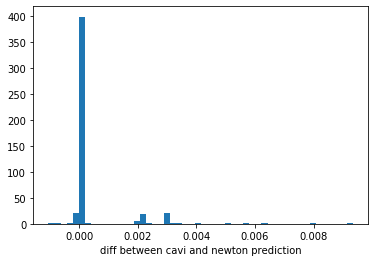

In [32]:
if continue_with_newton: 
    lr_newton_vb_free_params = \
        vb_sens_newton.predict_opt_par_from_hyper_par(
            prior_params_paragami['alpha'].flatten(prior_params_pert_dict['alpha'], free = use_free_alpha))
    
    plt.hist(lr_vb_free_params - lr_newton_vb_free_params, bins = 50);
    plt.xlabel('diff between cavi and newton prediction')

### re-optimize

In [33]:
new_init_dict = deepcopy(vb_cavi_dict)
# new_init_dict = deepcopy(init_vb_params_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [34]:
vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_pert_dict,
                                        gh_loc, gh_weights,
                                       debug = False)

vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)

done. num iterations = 16
stick_time: 0.087sec
cluster_time: 0.01sec
e_z_time: 0.028sec
**TOTAL time: 0.274sec**


### Compare linear response with refitting

In [35]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')

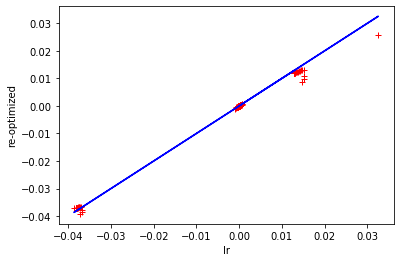

In [36]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_cavi_free)

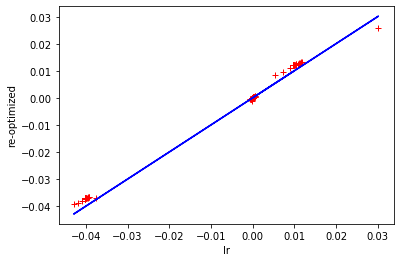

In [37]:
if continue_with_newton: 
    print_diff_plot(lr_newton_vb_free_params, vb_opt_pert, vb_cavi_free)

# Fit for a range of alpha 

In [38]:
alpha_list = np.arange(1, 15)

In [39]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                            vb_params_paragami, prior_params_pert_dict,
                                            gh_loc, gh_weights,
                                           debug = False)

    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert

### Re-optimize for range of alphas

In [40]:
print('alphas: ', alpha_list)

alphas:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [41]:
vb_pert_opt_array = []
for alpha in alpha_list: 
    print('\nre-optimzing with alpha = ', alpha)
    
    vb_pert_opt_array.append(refit_with_alpha(alpha, new_init_dict))


re-optimzing with alpha =  1
done. num iterations = 90
stick_time: 0.501sec
cluster_time: 0.044sec
e_z_time: 0.123sec
**TOTAL time: 1.496sec**

re-optimzing with alpha =  2
done. num iterations = 58
stick_time: 0.283sec
cluster_time: 0.027sec
e_z_time: 0.076sec
**TOTAL time: 0.907sec**

re-optimzing with alpha =  3
done. num iterations = 7
stick_time: 0.039sec
cluster_time: 0.004sec
e_z_time: 0.01sec
**TOTAL time: 0.119sec**

re-optimzing with alpha =  4
done. num iterations = 55
stick_time: 0.278sec
cluster_time: 0.026sec
e_z_time: 0.073sec
**TOTAL time: 0.882sec**

re-optimzing with alpha =  5
done. num iterations = 58
stick_time: 0.311sec
cluster_time: 0.032sec
e_z_time: 0.083sec
**TOTAL time: 0.975sec**

re-optimzing with alpha =  6
done. num iterations = 68
stick_time: 0.384sec
cluster_time: 0.04sec
e_z_time: 0.099sec
**TOTAL time: 1.195sec**

re-optimzing with alpha =  7
done. num iterations = 70
stick_time: 0.35sec
cluster_time: 0.035sec
e_z_time: 0.095sec
**TOTAL time: 1.123se

### get linear response prediction for each alpha

In [42]:
vb_pert_pred_array = []
vb_pert_pred_array_newton = []

for alpha in alpha_list: 
   
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # get linear response
    vb_pert_pred_array.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['alpha'].flatten(prior_params_pert_dict['alpha'], free = use_free_alpha)))
    
    if continue_with_newton: 
        vb_pert_pred_array_newton.append(vb_sens_newton.predict_opt_par_from_hyper_par(
            prior_params_paragami['alpha'].flatten(prior_params_pert_dict['alpha'], free = use_free_alpha)))

### examine results 

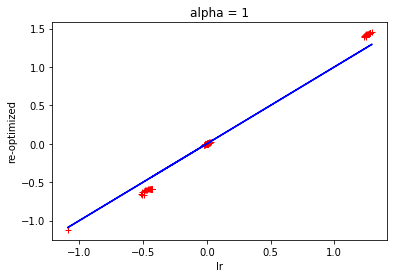

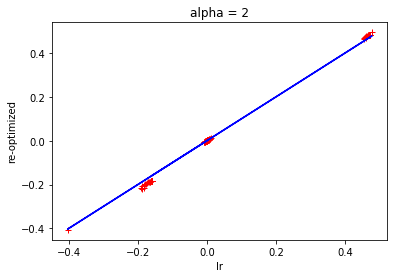

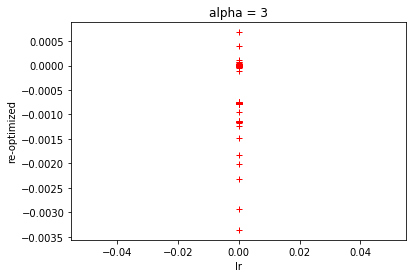

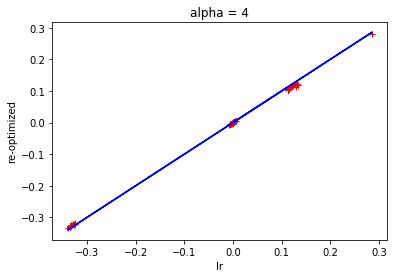

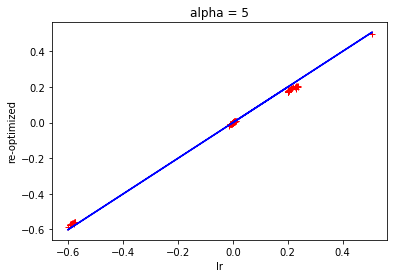

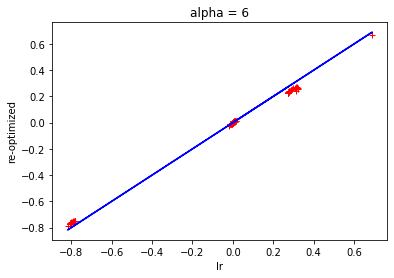

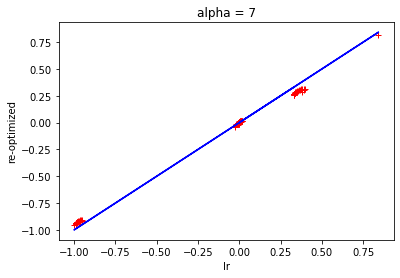

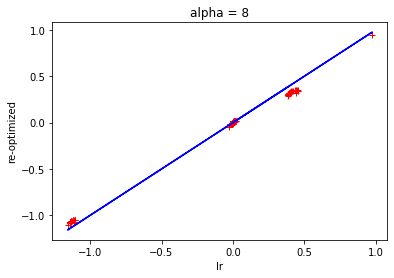

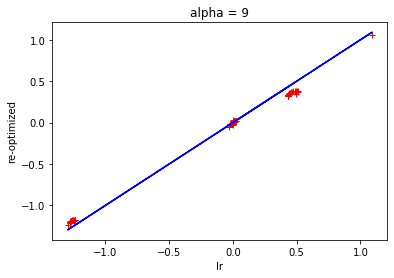

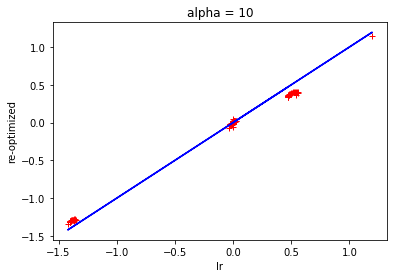

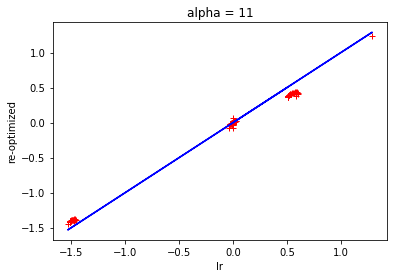

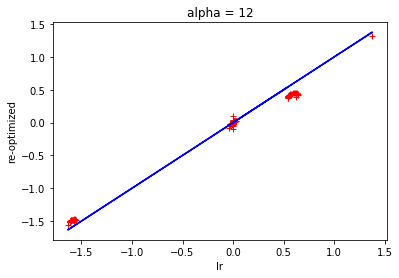

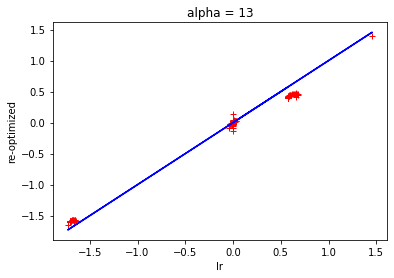

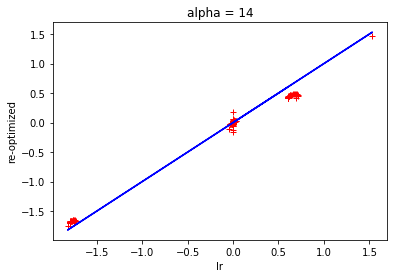

In [43]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(vb_pert_pred_array[i], vb_pert_opt_array[i], vb_cavi_free)
    
    plt.title('alpha = {}'.format(alpha_list[i]))
    
#     opt_dict = vb_params_paragami.fold(vb_opt, free = True)
#     lr_dict = vb_params_paragami.fold(vb_pert_pred_array[i], free = True)
#     pert_dict = vb_params_paragami.fold(vb_pert_opt_array[i], free = True)
    
# #     print_diff_plot(vb_params_paragami['stick_params'].flatten(lr_dict['stick_params'], free = True), 
# #                     vb_params_paragami['stick_params'].flatten(pert_dict['stick_params'], free = True), 
# #                     vb_params_paragami['stick_params'].flatten(opt_dict['stick_params'], free = True))
    
#     print_diff_plot(vb_params_paragami['cluster_params'].flatten(lr_dict['cluster_params'], free = True), 
#                 vb_params_paragami['cluster_params'].flatten(pert_dict['cluster_params'], free = True), 
#                 vb_params_paragami['cluster_params'].flatten(opt_dict['cluster_params'], free = True))



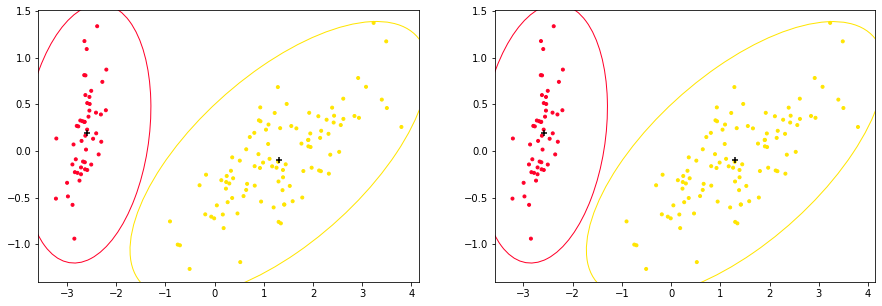

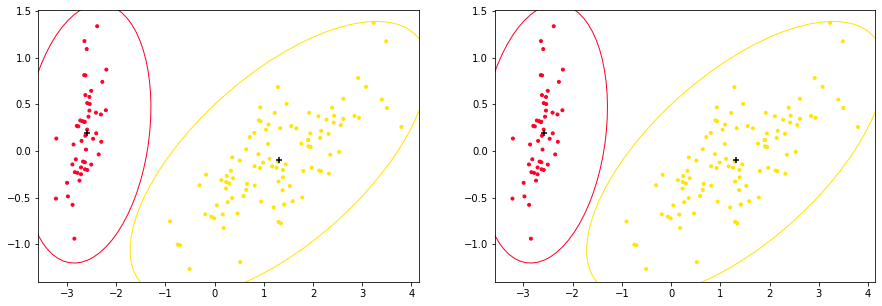

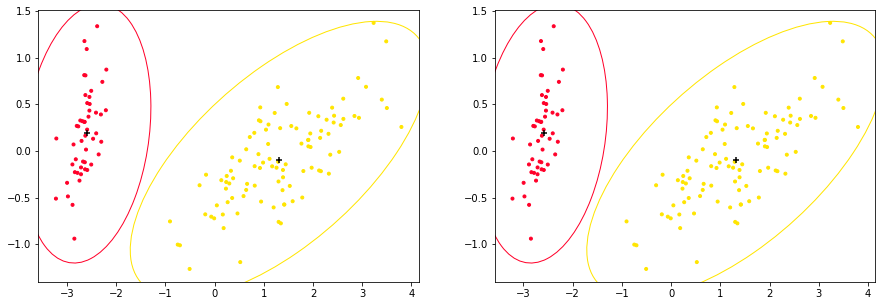

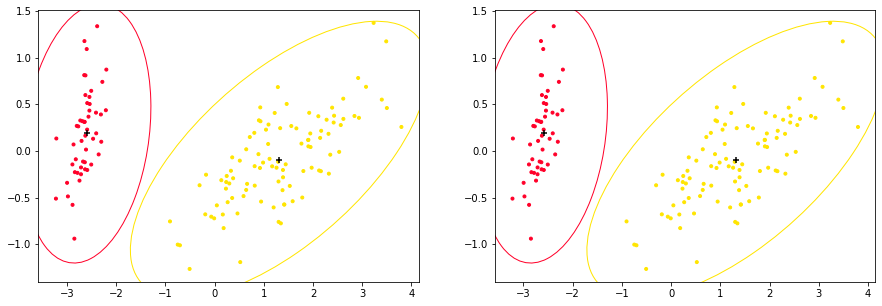

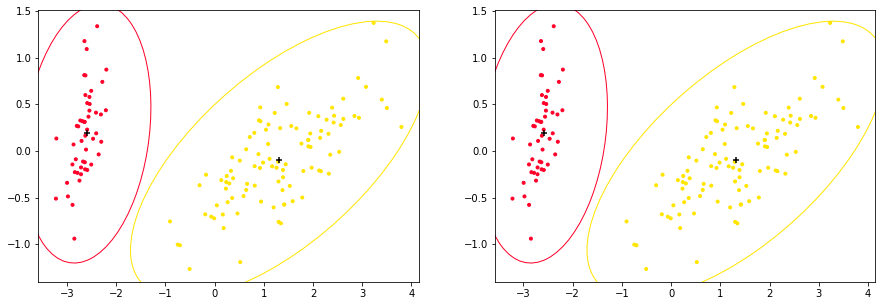

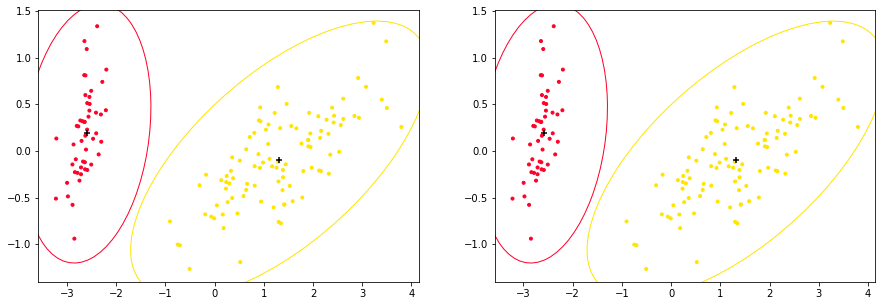

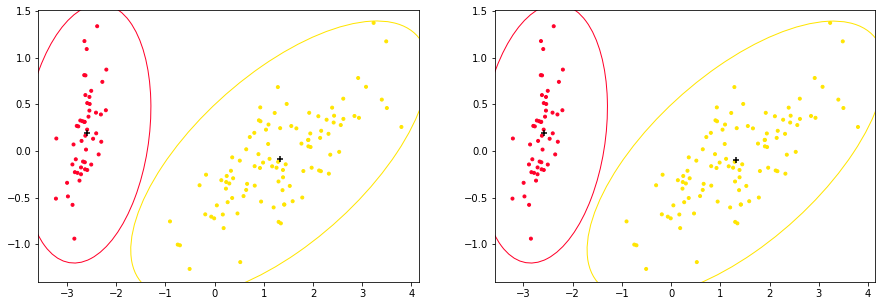

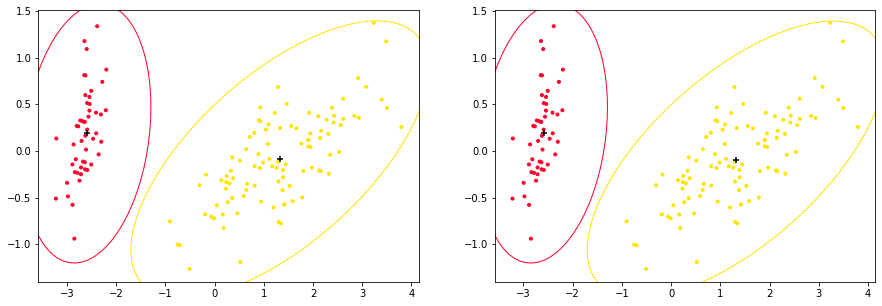

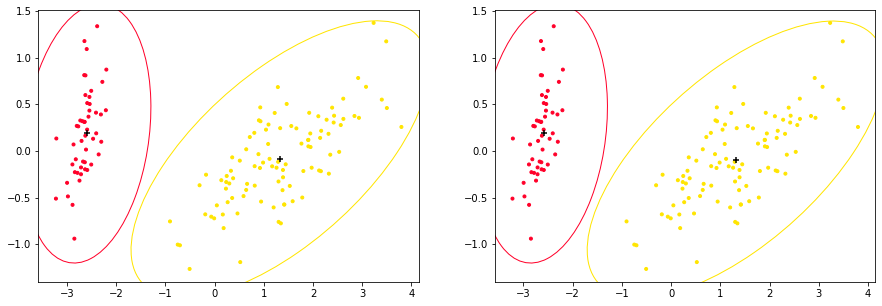

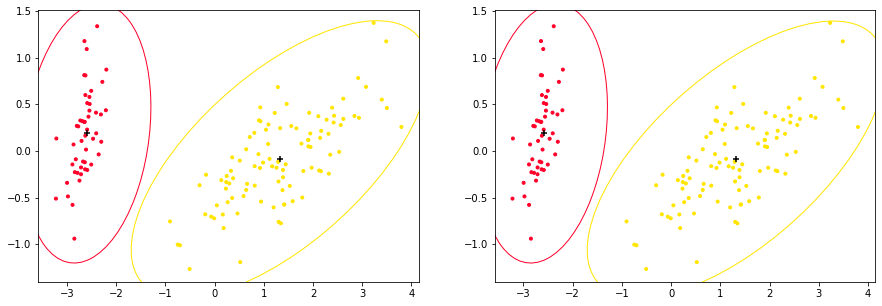

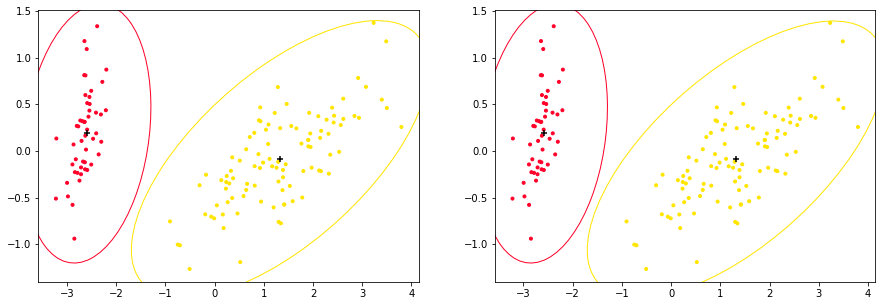

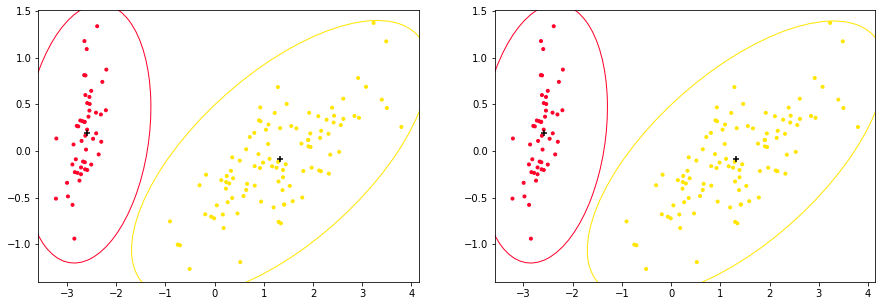

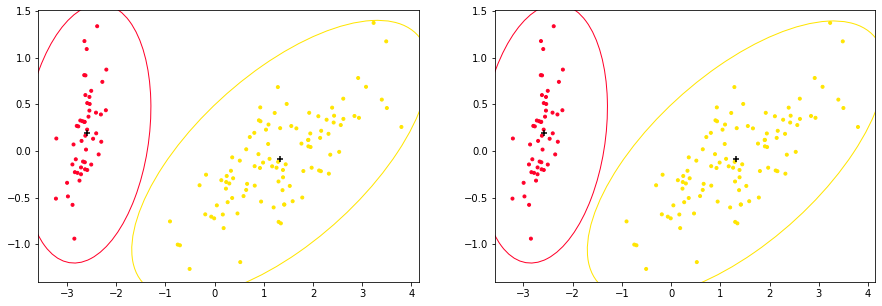

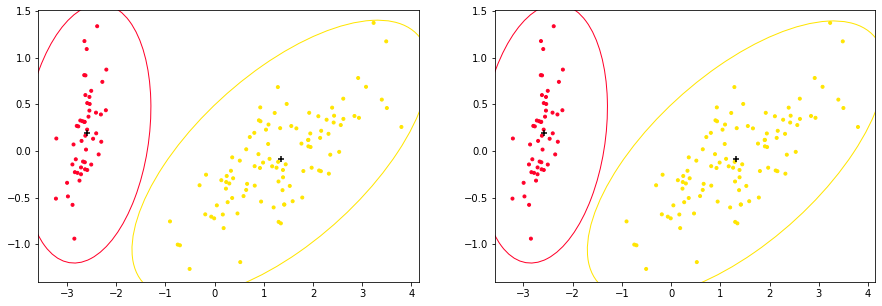

In [44]:
for i in range(len(alpha_list)): 

    fig, axes = plt.subplots(1, 2, figsize = (15, 5))

    lr_dict = vb_params_paragami.fold(vb_pert_pred_array[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_opt_array[i], free = True)

    plot_results_from_vb_params_dict(pca_fit, pert_dict, 
                                     gmm_lib.get_optimal_z_from_vb_params_dict(features, pert_dict,
                                                                                gh_loc, gh_weights), 
                                     axes[0])
    
    plot_results_from_vb_params_dict(pca_fit, lr_dict, 
                                     gmm_lib.get_optimal_z_from_vb_params_dict(features, lr_dict,
                                                                                gh_loc, gh_weights), 
                                     axes[1])
    

# Check results on number of clusters

### results on number of in-sample clusters

In [56]:
# threshold = 0

# lr_e_num_clusters_vec = np.zeros(len(alpha_list))
# refit_e_num_clusters_vec = np.zeros(len(alpha_list))

# for i in range(len(alpha_list)): 
#     # number of clusters as predicted by linear response
#     lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
#                                     vb_pert_pred_array[i],
#                                     gh_loc, gh_weights,
#                                     threshold = threshold,
#                                     n_samples = 100000)
    
#     lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
#     # number of clusters after refitting 
#     refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
#                                     vb_pert_opt_array[i],
#                                     gh_loc, gh_weights,
#                                     threshold = threshold,
#                                     n_samples = 100000)
    
#     refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


In [57]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_clusters_vec = np.zeros(len(alpha_list))
lr_newton_e_num_clusters_vec = np.zeros(len(alpha_list)) 

for i in range(len(alpha_list)): 
    
    # number of clusters after refitting 
    e_z_refit = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                                   vb_params_paragami.fold(vb_pert_opt_array[i], free = True), 
                                                   gh_loc, gh_weights)
    refit_e_num_clusters_vec[i] = cluster_lib.get_e_num_clusters_from_ez(e_z_refit)
    
    
    # number of clusters as predicted by linear response
    e_z_lr = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                                   vb_params_paragami.fold(vb_pert_pred_array[i], free = True), 
                                                   gh_loc, gh_weights)
    
    lr_e_num_clusters_vec[i] = cluster_lib.get_e_num_clusters_from_ez(e_z_lr)

    # same thing, but with newton's prediction
    if continue_with_newton: 
        e_z_lr_newton = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                                   vb_params_paragami.fold(vb_pert_pred_array_newton[i], 
                                                    free = True), 
                                                   gh_loc, gh_weights)
        lr_newton_e_num_clusters_vec[i] = cluster_lib.get_e_num_clusters_from_ez(e_z_lr_newton)
        
    
            


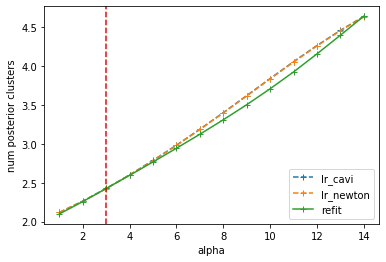

In [55]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--', label = 'lr_cavi')
plt.plot(alpha_list, lr_newton_e_num_clusters_vec, '+--', label = 'lr_newton')

plt.plot(alpha_list, refit_e_num_clusters_vec, '+-', label =  'refit')


plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend()

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')


### Results on posterior predictive clusters

In [58]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_pred_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_pred_array[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_opt_array[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


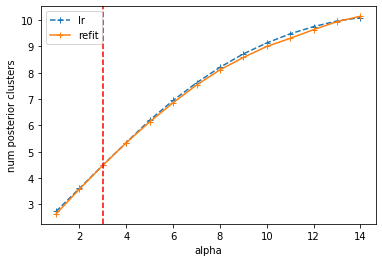

In [49]:
plt.plot(alpha_list, lr_e_num_pred_clusters_vec, '+--')

plt.plot(alpha_list, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')
